In [19]:
# 표준 라이브러리
import os
import requests
from IPython.display import Image, display
# 서드파티 라이브러리
import streamlit as st
import openai
from dotenv import load_dotenv
import json
from typing import List, Annotated, Literal, Dict, Callable, TypeVar, Tuple, Type, Generic, Optional, Union, Any
from typing_extensions import TypedDict  # TypedDict를 typing_extensions에서 import



# LangChain 및 LangGraph 관련 라이브러리
from langchain_openai import OpenAI
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import LLMChain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.language_models.chat_models import BaseChatModel
from langchain.agents import AgentExecutor
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain.tools import tool

from langgraph.types import Command
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langsmith import utils 
from agents.agent_library import agent_configs, AgentConfig
from datetime import datetime, timedelta
from dateutil.parser import parse
import yfinance as yf
import pandas as pd
from langchain_openai import ChatOpenAI


In [20]:
# 환경 변수 로드
load_dotenv()
print(utils.tracing_is_enabled())

MODEL_NAME = "gemma2-9b-it"

True


In [3]:
small_llm = ChatGroq(
    model=MODEL_NAME,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

In [4]:
# Polygon API를 초기화
polygon = PolygonAPIWrapper()
polygon_toolkit = PolygonToolkit.from_polygon_api_wrapper(polygon)
polygon_tools = polygon_toolkit.get_tools()


In [5]:
polygon_tools

[PolygonAggregates(api_wrapper=PolygonAPIWrapper(polygon_api_key='Il8sVXYP3rj8_qxduX1XFSqR8MzW6KNr')),
 PolygonLastQuote(api_wrapper=PolygonAPIWrapper(polygon_api_key='Il8sVXYP3rj8_qxduX1XFSqR8MzW6KNr')),
 PolygonTickerNews(api_wrapper=PolygonAPIWrapper(polygon_api_key='Il8sVXYP3rj8_qxduX1XFSqR8MzW6KNr')),
 PolygonFinancials(api_wrapper=PolygonAPIWrapper(polygon_api_key='Il8sVXYP3rj8_qxduX1XFSqR8MzW6KNr'))]

In [6]:
# 시장 조사 도구 
market_research_tools =  polygon_tools

# 시장 조사 에이전트
market_research_agent = create_react_agent(
    llm, 
    tools=market_research_tools, 
    state_modifier='You are a market researcher. Provide fact only not opinions'
)

def market_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    시장 조사 node. 주어진 state를 기반으로 시장 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    # 시장 조사 에이전트를 호출하여 결과를 얻습니다.
    result = market_research_agent.invoke(state)
    
    print(f"market_result===={result}")
    # 결과 메시지를 업데이트하고 supervisor node로 이동합니다.
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_research')]},
        goto='supervisor'
    )

In [7]:

@tool
def get_stock_price(ticker: str) -> dict:
    """Given a stock ticker, return the price data for the past month"""
    stock_info = yf.download(ticker, period='1mo').to_dict()
    return stock_info

def stock_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    주식 조사 node
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = stock_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='stock_research')]},
        goto='supervisor'
    )



stock_research_tools = [get_stock_price]
stock_research_agent = create_react_agent(
    llm, tools=stock_research_tools, state_modifier='You are a stock researcher. Provide facts only not opinions'
)


In [8]:
def filter_financial_info(financial_dict: dict) -> pd.DataFrame:
    """
    손익계산서 데이터에서 핵심 지표만 필터링하는 함수
    
    :param financial_dict: company_research_tool("BE")로 가져온 dict 데이터
    :return: 필터링된 DataFrame (핵심 재무 지표만 포함)
    """
    # financial_info 키에서 DataFrame 가져오기
    financial_data = financial_dict.get("financial_info", pd.DataFrame())
    
    if financial_data.empty:
        return financial_data  # 데이터가 없으면 그대로 반환
    
    # 남길 핵심 지표 리스트 (각 지표 설명 포함)
    key_metrics = [
        "TotalRevenue",  # 총 매출 (회사의 전체 매출액)
        "CostOfRevenue",  # 매출 원가 (제품 또는 서비스 제공 비용)
        "GrossProfit",  # 매출 총이익 (총 매출 - 매출 원가)
        "OperatingIncome",  # 영업이익 (주요 영업 활동에서 발생한 이익)
        "EBITDA",  # 상각전영업이익 (세금, 이자, 감가상각비 제외 이익)
        "EBIT",  # 이자 및 세금 차감 전 이익 (운영 성과 평가용)
        "NetIncome",  # 순이익 (최종 이익, 모든 비용과 세금 차감 후)
        "BasicEPS",  # 기본 주당순이익 (보통주 한 주당 이익)
        "DilutedEPS",  # 희석 주당순이익 (옵션, 채권 등을 고려한 주당순이익)
        "InterestExpense",  # 이자 비용 (부채에 대한 이자 지급 비용)
        "TaxProvision"  # 법인세 비용 (기업이 납부해야 하는 세금)
    ]
    
    return financial_data.loc[financial_data.index.intersection(key_metrics)]


def filter_sec_filings(sec_filings, report_types=None):
    """
    SEC Filings에서 1년 이내 데이터만 가져오고, 특정 리포트 유형을 필터링하며, EXCEL 파일은 제외.
    
    - report_types가 None이면 모든 리포트를 가져옴
    - 특정 리스트가 들어오면 해당 유형만 필터링
    """
    one_year_ago = datetime.today() - timedelta(days=50)

    filtered_filings = []
    for filing in sec_filings:
        filing_date = parse(str(filing["date"]))  # 날짜 변환
        is_recent = filing_date >= one_year_ago
        is_valid_type = report_types is None or filing["type"] in report_types 
        
        if is_recent and is_valid_type:
            # EXCEL 파일을 제외한 exhibits 필터링
            filtered_exhibits = {key: value for key, value in filing["exhibits"].items() if key != "EXCEL"}
            
            filtered_filings.append({
                "date": filing["date"],
                "type": filing["type"],
                "title": filing["title"],
                "exhibits": filtered_exhibits  # 필터링된 exhibits 추가
            })
    
    return filtered_filings

@tool
def company_research_tool(ticker: str) -> dict:
    """Given a ticker, return the financial information and SEC filings"""
    company_info = yf.Ticker(ticker)
    financial_info = company_info.get_financials( freq="quarterly")
    sec_filings = company_info.get_sec_filings()

    filtered_financial_info = filter_financial_info(financial_info)
    filtered_filings = filter_sec_filings(sec_filings)
    
    return {
        'financial_info': filtered_financial_info,
        'sec_filings': filtered_filings
    }



def company_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    회사 조사 node

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = company_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='company_research')]},
        goto='supervisor'
    )


company_research_tools = [company_research_tool]
company_research_agent = create_react_agent(
    llm, tools=company_research_tools, state_modifier='You are a company researcher. Provide facts only not opinions'
)


In [9]:
from langchain_core.prompts import PromptTemplate

analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information, 
Please decide wheter to buy, sell, or hold the stock.

Information:
{messages}"""
)

analyst_chain = analyst_prompt | llm

def analyst_node(state: MessagesState):
    """
    분석가 node

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환
    """
    result = analyst_chain.invoke({'messages': state['messages'][1:]})

    return {'messages': [result]}

In [10]:

from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["market_research", "stock_research", "company_research"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



def supervisor_node(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node 
    주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정
    모든 작업이 완료되면 analyst node로 이동

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령 반환 
    """
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

In [11]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("market_research", market_research_node)
graph_builder.add_node("stock_research", stock_research_node)
graph_builder.add_node("company_research", company_research_node)
graph_builder.add_node("analyst", analyst_node)

graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)
graph = graph_builder.compile()

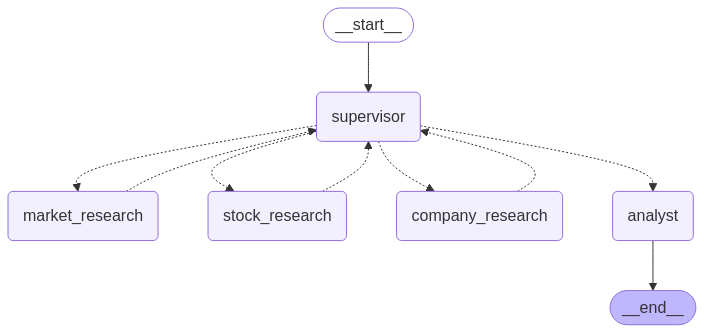

In [12]:
graph

In [13]:
for chunk in graph.stream(
    {"messages": [("user", "Would you invest in Snowflake?")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Would you invest in Snowflake?
================================ Human Message =================================
Name: company_research

Here is some factual information about Snowflake (ticker: SNOW):

1. Financial Information:
   - The financial data provided appears to be empty or unavailable at this moment.

2. SEC Filings:
   - **March 6, 2025**: An 8-K filing regarding corporate changes and voting matters. [View Document](https://cdn.yahoofinance.com/prod/sec-filings/0001640147/000164014725000027/snow-20250304.htm)
   - **February 26, 2025**: An 8-K filing about corporate changes and voting matters, including a consulting agreement exhibit. [View 8-K Document](https://cdn.yahoofinance.com/prod/sec-filings/0001640147/000164014725000017/snow-20250225.htm) | [View EX-10.1 Document](https://cdn.yahoofinance.com/prod/sec-filings/0001640147/000164014725000017/consultingagreement-mikesc.htm)

For detailed a

[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: stock_research

Here's the stock price data for Snowflake (SNOW) over the past month:

| Date       | Open     | High     | Low      | Close    | Volume    |
|------------|----------|----------|----------|----------|-----------|
| 2025-02-13 | 186.96   | 192.77   | 185.20   | 192.66   | 5,686,400 |
| 2025-02-14 | 192.86   | 193.00   | 184.07   | 187.60   | 5,812,300 |
| 2025-02-18 | 193.60   | 194.40   | 189.09   | 192.78   | 7,308,900 |
| 2025-02-19 | 189.20   | 192.00   | 186.19   | 186.56   | 5,089,000 |
| 2025-02-20 | 186.00   | 186.18   | 178.55   | 184.96   | 5,423,800 |
| 2025-02-21 | 184.90   | 185.93   | 176.35   | 177.89   | 5,324,200 |
| 2025-02-24 | 177.58   | 177.70   | 167.30   | 170.92   | 6,482,100 |
| 2025-02-25 | 168.79   | 169.96   | 160.66   | 164.20   | 7,163,200 |
| 2025-02-26 | 166.00   | 170.01   | 164.80   | 166.19   | 12,755,700|
| 2025-02-27 | 187.01   | 187.95   | 173.59  

In [21]:
# SEC API 엔드포인트
SEC_API_URL = "https://api.sec-api.io/insider-trading"
SEC_API_KEY = os.getenv("SEC_API_KEY")

def build_query(ticker: str = None, owner: str = None, transaction_type: str = None, 
                start_date: str = None, end_date: str = None) -> str:
    """
    사용자가 입력한 간단한 파라미터를 Lucene Query 형식으로 변환하는 함수
    
    :param ticker: 기업 티커 (예: TSLA)
    :param owner: 내부자 이름 (예: Elon Musk)
    :param transaction_type: 거래 유형 (예: A, D, P 등)
    :param start_date: 검색 시작 날짜 (YYYY-MM-DD)
    :param end_date: 검색 종료 날짜 (YYYY-MM-DD)
    :return: Lucene Query 형식의 문자열
    """
    conditions = []

    if ticker:
        conditions.append(f"issuer.tradingSymbol:{ticker.upper()}")

    if owner:
        conditions.append(f"reportingOwner.name:\"{owner}\"")

    if transaction_type:
        conditions.append(f"nonDerivativeTable.transactions.coding.code:{transaction_type}")

    if start_date and end_date:
        conditions.append(f"periodOfReport:[{start_date} TO {end_date}]")
    elif start_date:
        conditions.append(f"periodOfReport:[{start_date} TO *]")  # 특정 날짜 이후 거래 검색
    elif end_date:
        conditions.append(f"periodOfReport:[* TO {end_date}]")  # 특정 날짜 이전 거래 검색

    return " AND ".join(conditions) if conditions else "*:*"  # 조건이 없으면 전체 조회


def fetch_insider_trades(
        ticker: str = None, owner: str = None, 
        transaction_type: str = None, start_date: str = None, 
        end_date: str = None, from_value: int = 0
        ):
    """
    SEC Insider Trading API를 호출하여 내부자 거래 데이터를 가져옴.
    
    :param ticker: 기업 티커 (예: TSLA)
    :param owner: 내부자 이름 (예: Elon Musk)
    :param transaction_type: 거래 유형 (예: A, D, P 등)
    :param start_date: 검색 시작 날짜 (YYYY-MM-DD)
    :param end_date: 검색 종료 날짜 (YYYY-MM-DD)
    :param from_value: 페이징 시작 위치 (기본값 0)
    :return: 응답 JSON 데이터 (dict 형태)
    """
    headers = {
        "Authorization": SEC_API_KEY,
        "Content-Type": "application/json",
        "User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36"
    }

    # 쿼리 자동 생성
    query = build_query(ticker, owner, transaction_type, start_date, end_date)

    payload = {
        "query": query,
        "from": from_value,
        "size": 5,  #  size는 5로 고정
        "sort": [{ "filedAt": { "order": "desc" } }]  # 최신 데이터부터 정렬
    }

    response = requests.post(SEC_API_URL, headers=headers, data=json.dumps(payload))

    if response.status_code == 200:
        return response.json()
    else:
        print(f"요청 실패 상태 코드: {response.status_code}, 응답: {response.text}")
        return None


In [24]:
def filter_sec_response(response_data):
    """
    SEC API 응답 데이터를 필터링하여 필요한 정보만 반환하는 함수.

    :param response_data: API 응답 JSON (dict)
    :return: 필터링된 데이터 (Dict[list]
    """
    filtered_transactions = []

    for transaction in response_data.get("transactions", []):
        filtered_transaction = {
            "accessionNo": transaction.get("accessionNo"),
            "filedAt": transaction.get("filedAt")[:10],  # 날짜만 남기기 (YYYY-MM-DD)
            "periodOfReport": transaction.get("periodOfReport"),
            "documentType": transaction.get("documentType"),
            "issuer": {
                "name": transaction["issuer"]["name"],
                "tradingSymbol": transaction["issuer"]["tradingSymbol"]
            },
            "reportingOwner": {
                "name": transaction["reportingOwner"]["name"],
                "relationship": {
                    "isDirector": transaction["reportingOwner"]["relationship"].get("isDirector", False),
                    "isOfficer": transaction["reportingOwner"]["relationship"].get("isOfficer", False),
                    "officerTitle": transaction["reportingOwner"]["relationship"].get("officerTitle", ""),
                    "isTenPercentOwner": transaction["reportingOwner"]["relationship"].get("isTenPercentOwner", False)
                }
            },
            "nonDerivativeTransactions": [],
            "derivativeTransactions": [],
            "footnotes": [footnote["text"] for footnote in transaction.get("footnotes", [])]
        }

        # 비파생상품 거래 필터링 (모든 거래 유형 유지)
        for trans in transaction.get("nonDerivativeTable", {}).get("transactions", []):
            filtered_transaction["nonDerivativeTransactions"].append({
                "transactionDate": trans.get("transactionDate"),
                "securityTitle": trans.get("securityTitle"),
                "shares": trans["amounts"]["shares"],
                "pricePerShare": trans["amounts"]["pricePerShare"] if trans["amounts"]["pricePerShare"] != 0 else None,
                "acquiredDisposedCode": trans["coding"]["code"],  
                "sharesOwnedAfter": trans["postTransactionAmounts"]["sharesOwnedFollowingTransaction"]
            })

        # 파생상품 거래 필터링 (모든 거래 유형 유지)
        for trans in transaction.get("derivativeTable", {}).get("transactions", []):
            filtered_transaction["derivativeTransactions"].append({
                "transactionDate": trans.get("transactionDate"),
                "securityTitle": trans.get("securityTitle"),
                "conversionOrExercisePrice": trans["conversionOrExercisePrice"],
                "shares": trans["amounts"]["shares"],
                "acquiredDisposedCode": trans["coding"]["code"],  
                "expirationDate": trans.get("expirationDate")
            })

        filtered_transactions.append(filtered_transaction)

    return filtered_transactions


In [22]:
tesla_trades = fetch_insider_trades(ticker="TSLA")


In [26]:
filter_sec_response(tesla_trades)[0]

{'accessionNo': '0001771340-25-000004',
 'filedAt': '2025-03-12',
 'periodOfReport': '2025-03-10',
 'documentType': '4',
 'issuer': {'name': 'Tesla, Inc.', 'tradingSymbol': 'TSLA'},
 'reportingOwner': {'name': 'MURDOCH JAMES R',
  'relationship': {'isDirector': True,
   'isOfficer': False,
   'officerTitle': '',
   'isTenPercentOwner': False}},
 'nonDerivativeTransactions': [{'transactionDate': '2025-03-10',
   'securityTitle': 'Common Stock',
   'shares': 180000,
   'pricePerShare': 23.85,
   'transactionType': 'A',
   'sharesOwnedAfter': 180000},
  {'transactionDate': '2025-03-10',
   'securityTitle': 'Common Stock',
   'shares': 351787,
   'pricePerShare': 24.73,
   'transactionType': 'A',
   'sharesOwnedAfter': 531787},
  {'transactionDate': '2025-03-10',
   'securityTitle': 'Common Stock',
   'shares': 54776,
   'pricePerShare': 240.788,
   'transactionType': 'D',
   'sharesOwnedAfter': 477011}],
 'derivativeTransactions': [{'transactionDate': '2025-03-10',
   'securityTitle': 'No